In [1]:
%pip install numpy matplotlib numba tqdm scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
import numba
from numba import prange
from tqdm import tqdm
import os
from matplotlib.patches import Circle
from matplotlib.ticker import ScalarFormatter, FuncFormatter

/home/malyadeep/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Create a grid, drop and streamlines

In [3]:
x, y = np.mgrid[-0.5:0.5:101j, -0.5:0.5:101j]
radius = 0.3
center_x, center_y = 0, 0

In [4]:
velocity = 1
psi = np.zeros((101, 101), dtype=np.float64)
for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        r = np.sqrt(x[i, j] * x[i, j] + y[i, j] * y[i, j])
        theta = np.arctan2(y[i, j], x[i, j])
        if theta > np.pi:
            theta = 2 * np.pi - theta
        if j < y.shape[0] // 2:
            psi[i, j] = - 0.5 * velocity * r * r * (radius**2 - r**2) * (np.sin(theta))**2
        else:
            psi[i, j] = 0.5 * velocity * r * r * (radius**2 - r**2) * (np.sin(theta))**2
ux = np.zeros((101, 101))
uy = np.zeros((101, 101))
for i in range(1, x.shape[0] - 1):
    for j in range(1, y.shape[0] - 1):
        if x[i, j] * x[i, j] + y[i, j] * y[i, j] < radius * radius:
            ux[i, j] = (psi[i, j + 1] - psi[i, j - 1])/2
            uy[i, j] = - (psi[i + 1, j] - psi[i - 1, j])/2

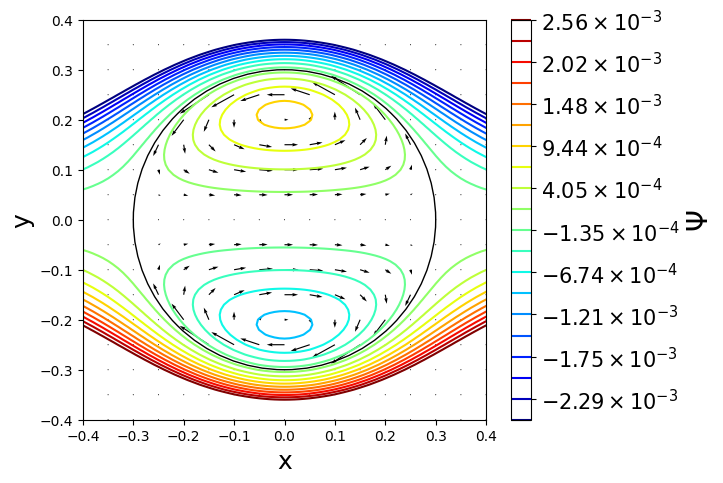

In [5]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


if not os.path.isdir("figures_plot"):
    os.makedirs("figures_plot")
skip = 5
levels = np.linspace(- 0.05 * np.max(psi), 0.05 * np.max(psi), 20)
cmap = mpl.colormaps.get_cmap("jet")
fig = plt.figure(1, figsize=(7, 5))
ax = fig.add_axes([0.10, 0.15, 0.72, 0.80])
CS = ax.contour(x, y, psi, levels=levels, cmap=cmap)
circle = Circle((center_x, center_y), radius, fill=False)
ax.add_patch(circle)
ax.quiver(x[::skip, ::skip], y[::skip, ::skip], ux[::skip, ::skip], uy[::skip, ::skip],
          scale=2e-3)
cbar = plt.colorbar(CS, format=FuncFormatter(fmt))
cbar.set_label(r"$\Psi$", size=20)
cbar.ax.tick_params(labelsize=15)
ax.set_xlabel(r"x", fontsize=18)
ax.set_ylabel(r"y", fontsize=18)
ax.set_xlim(-0.4, 0.4)
ax.set_ylim(-0.4, 0.4)
plt.savefig("figures_plot/streamLines.png")

## Simulate a tracer

### Choosing spatial points

In [6]:
r = np.linspace(0, 0.3, 11)
theta = np.linspace(0, 180, 11) * np.pi / 180
print(r, theta * 180 / np.pi)
polarCoordinates = np.dstack(np.meshgrid(r, theta)).reshape(-1, 2)

[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3 ] [  0.  18.  36.  54.  72.  90. 108. 126. 144. 162. 180.]


In [7]:
cartesianCoordinates = np.zeros_like(polarCoordinates)
x = np.multiply(r, np.cos(theta))
y = np.multiply(r, np.sin(theta))
cartesianCoordinates[:, 0] = np.multiply(polarCoordinates[:, 0], np.cos(polarCoordinates[:, 1]))
cartesianCoordinates[:, 1] = np.multiply(polarCoordinates[:, 0], np.sin(polarCoordinates[:, 1]))
print(x, y)
# print(cartesianCoordinates)

[ 0.00000000e+00  2.85316955e-02  4.85410197e-02  5.29006727e-02
  3.70820393e-02  9.18485099e-18 -5.56230590e-02 -1.23434903e-01
 -1.94164079e-01 -2.56785259e-01 -3.00000000e-01] [0.00000000e+00 9.27050983e-03 3.52671151e-02 7.28115295e-02
 1.14126782e-01 1.50000000e-01 1.71190173e-01 1.69893569e-01
 1.41068461e-01 8.34345885e-02 3.67394040e-17]


In [8]:
fig = plt.figure(1, figsize=(7, 4))
ax = fig.add_axes([0.10, 0.15, 0.82, 0.80])
circle = Circle((center_x, center_y), radius, fill=False)
ax.add_patch(circle)
cmap = mpl.colormaps.get_cmap("jet")
scat = ax.scatter(cartesianCoordinates[:, 0], cartesianCoordinates[:, 1],
                  marker='o', s=20, edgecolors="black", facecolors="black")
ax.set_xlabel(r"x", fontsize=18)
ax.set_ylabel(r"y", fontsize=18)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4], fontsize=15)
ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
ax.set_xticklabels([-0.4, -0.2, 0, 0.2, 0.4], fontsize=15)
ax.set_xlim(-0.45, 0.45)
ax.set_ylim(-0.03, 0.43)
plt.savefig("figures_plot/grid_sde.png")
plt.close()

### Path Integration

In [9]:
@numba.njit
def velocityAnalytical(x, y, U, radius):
    ux = U * y * (radius**2 - x**2 - 2 * y**2)
    uy = U * x * y**2
    return ux, uy


@numba.njit
def computePsi(x, y, U, radius):
    r = np.sqrt(x * x + y * y)
    theta = np.arctan2(y, x)
    psi = 0.5 * U * r * r * (radius**2 - r**2) * (np.sin(theta))**2
    return psi


@numba.njit
def pathIntegrate(x_0, time, dt, velocity, radius, noiseCoeff=0):
    noOfSteps = int(time / dt)
    times = np.linspace(0, time, noOfSteps + 1)
    x_particle = np.zeros((noOfSteps + 1, 2), dtype=np.float64)
    x_particle[0, :] = np.copy(x_0)
    escapeTime = -1
    escaped = False
    for step in range(1, noOfSteps + 1):
        velocity_x, velocity_y = \
            velocityAnalytical(x_particle[step - 1, 0], x_particle[step - 1, 1],
                               velocity, radius)
        noise_x = np.random.normal(0, 1)
        noise_y = np.random.normal(0, 1)
        # Simplectic Euler
        x_intermediate = x_particle[step - 1, 0] + velocity_x * dt
        y_intermediate = x_particle[step - 1, 1] + velocity_y * dt
        velocity_x_intermediate, velocity_y_intermediate = \
            velocityAnalytical(x_intermediate, y_intermediate,
                               velocity, radius)
        x_particle[step, 0] = x_particle[step - 1, 0] + 0.5 *\
            (velocity_x + velocity_x_intermediate) * dt +\
            noiseCoeff * noise_x * np.sqrt(dt)
        x_particle[step, 1] = x_particle[step - 1, 1] + 0.5 *\
            (velocity_y + velocity_y_intermediate) * dt +\
            noiseCoeff * noise_y * np.sqrt(dt)
        if (x_particle[step, 0] * x_particle[step, 0] + x_particle[step, 1] * x_particle[step, 1]
                > radius * radius and escaped is False):
            escapeTime = times[step]
            escaped = True
    return times, x_particle, escapeTime


@numba.njit(parallel=True)
def multiTrajectorySimulation(x_0, time, dt, noiseCoeff, noOfRuns):
    escapeTimes = np.zeros(noOfRuns, dtype=np.float64)
    for run in prange(noOfRuns):
        times, x_particle, escapeTime = pathIntegrate(x_0, time, dt, velocity, radius, noiseCoeff=noiseCoeff)
        escapeTimes[run] = escapeTime
    return escapeTimes

In [10]:
run_multiTrajectory = False
radius = 0.3
velocity = 1
time = 30000
dt = 1e-2
noiseCoeff = 1e-3      ## Set to non zero value to add a Gaussian noise
## Warmup
numba.set_num_threads(16)
noOfRuns = 1
x_0 = np.zeros(2)
escapeTimes = multiTrajectorySimulation(x_0, time, dt, noiseCoeff, noOfRuns)
## Actual Simulation
if run_multiTrajectory is True:
    noOfRuns = 50000
    escapeTimes_all = np.zeros((cartesianCoordinates.shape[0], noOfRuns))
    numba.set_num_threads(128)
    for itr in tqdm(range(cartesianCoordinates.shape[0])):
        x_0 = cartesianCoordinates[itr]
        psi_0 = computePsi(x_0[0], x_0[1], velocity, radius)
        escapeTimes = multiTrajectorySimulation(x_0, time, dt, noiseCoeff, noOfRuns)
        escapeTimes_all[itr] = escapeTimes

In [11]:
save_data = False
if save_data is True:
    if not os.path.isdir("output"):
        os.makedirs("output")
    np.savez("output/escapeTimes_improvedEuler_N_121.npz",
             escapeTimes=escapeTimes_all, polarCoordinates=polarCoordinates,
             cartesianCoordinates=cartesianCoordinates)

## Load and plot distribution

In [12]:
load_plot_data = True
if load_plot_data is True:
    data = np.load("output/escapeTimes_improvedEuler_N_121.npz")
    escapeTimes_all = data["escapeTimes"]
    cartesianCoordinates = data["cartesianCoordinates"]
    polarCoordinates = data["polarCoordinates"]
print(escapeTimes_all.shape)

(121, 50000)


In [13]:
noOfEscapes = np.zeros(polarCoordinates.shape[0], dtype=np.int64)
if load_plot_data is True:
    escapeTimes_filtered_all = []
    for itr in range(polarCoordinates.shape[0]):
        escapeTimes_filtered = []
        escapeTimes = escapeTimes_all[itr]
        for i in range(escapeTimes.shape[0]):
            if escapeTimes[i] >= 0:
                escapeTimes_filtered.append(escapeTimes[i])
        escapeTimes_filtered = np.array(escapeTimes_filtered)
        escapeTimes_filtered_all.append(escapeTimes_filtered)
        noOfEscapes[itr] = escapeTimes_filtered.shape[0]
print(noOfEscapes)

[49961 49979 49975 49969 49971 49979 49975 49978 49985 49984 50000 49961
 49974 49976 49936 49916 49898 49853 49854 49879 49894 50000 49973 49965
 49902 49799 49712 49593 49504 49389 49455 49671 49999 49974 49960 49836
 49652 49465 49223 48990 48898 49000 49362 49999 49977 49928 49788 49539
 49173 48881 48549 48449 48490 49085 49997 49983 49935 49740 49465 49089
 48670 48409 48222 48310 48921 49996 49976 49946 49777 49508 49215 48880
 48550 48402 48519 49047 49999 49965 49957 49861 49650 49455 49177 48924
 48822 48938 49323 49997 49971 49959 49913 49808 49701 49572 49483 49376
 49468 49651 50000 49972 49975 49955 49955 49914 49885 49854 49843 49861
 49897 49999 49976 49964 49971 49969 49968 49963 49971 49969 49976 49986
 50000]


In [14]:
probOfEscape = noOfEscapes / 50000

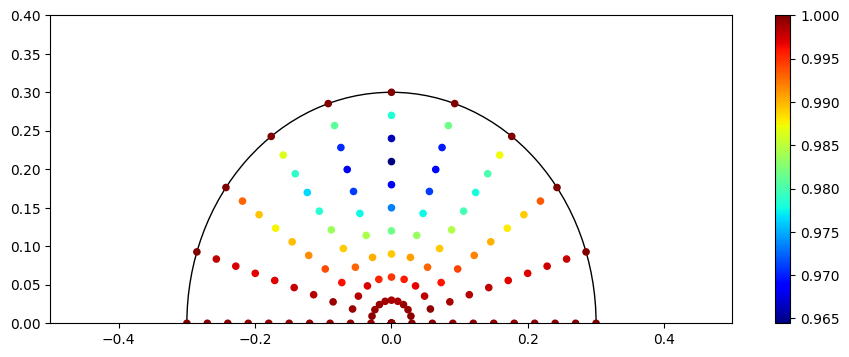

In [15]:
fig = plt.figure(1, figsize=(11, 4))
ax = plt.gca()
cmap = mpl.colormaps.get_cmap("jet")
circle = Circle((center_x, center_y), radius, fill=False)
ax.add_patch(circle)
scat = ax.scatter(cartesianCoordinates[:, 0], cartesianCoordinates[:, 1],
                  marker='o', s=20, c=probOfEscape, cmap=cmap)
plt.colorbar(scat)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(0, 0.4)
plt.show()

## Poisson Distribution?

In [16]:
from scipy.optimize import curve_fit

def logNormal(t, mu, sigma):
    return (1 / (t * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(t) - mu)**2 / (2 * sigma * sigma))

In [17]:
if not os.path.isdir("figures_fit"):
    os.makedirs("figures_fit")
interval = 100
meanEscapeTime = np.zeros(len(escapeTimes_filtered_all))
variance = np.zeros_like(meanEscapeTime)
for itr in range(len(escapeTimes_filtered_all)):
    escapeTimes_sorted = np.sort(escapeTimes_filtered_all[itr])
    r = polarCoordinates[itr, 0]
    theta = polarCoordinates[itr, 1]
    totalTime = 10000
    N = totalTime//interval
    timesFit = np.linspace(0, N * interval, N + 1)
    num, bins = np.histogram(escapeTimes_sorted, bins=N, density=True)
    popt, pcov = curve_fit(logNormal, bins[1:], num)
    logNormDist = logNormal(bins[1:], *popt)
    mu_log = popt[0]
    sigma_log = popt[1]
    meanEscapeTime[itr] = np.sqrt(np.exp(2 * mu_log + sigma_log**2))
    variance[itr] = (np.exp(sigma_log**2) - 1) * mu_log * mu_log
    ## Plotting
    plt.figure(1)
    ax = plt.gca()
    ax.hist(escapeTimes_sorted, bins=100, density=True, color="blue", alpha=0.3, label="Simulation")
    ax.plot(bins[1:], logNormDist, color="red", label="Log-Normal")
    ax.set_xlabel(r"$t$", fontsize=15)
    ax.set_ylabel(r"$p(t)$", fontsize=15)
    ax.get_yaxis().set_major_formatter(ScalarFormatter(useOffset=True, useMathText=True))
    ax.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))
    ax.legend(loc="best", fontsize=14, frameon=False)
    plt.title("r = " + str(np.round(r, 3)) + r", $\theta$ = "
              + str(np.round(theta * 180 / np.pi, 2)) +
              r", $N_e$ = " + str(noOfEscapes[itr]) + r", $t_{\mu}$ = " +
              str(np.round(meanEscapeTime[itr], 2)))
    plt.savefig("figures_fit/r_" + str(np.round(r, 3)) + "_theta_"
              + str(np.round(theta * 180 / np.pi, 2)) + ".png")
    plt.close()

## Pretty Plots

In [18]:
if not os.path.isdir("figures_plot"):
    os.makedirs("figures_plot")
interval = 100
yticks_all = [[0, 0.4e-3, 0.8e-3, 1.2e-3],
              [0, 2e-5, 4e-5, 6e-5, 8e-5],
              [0, 0.4e-4, 0.8e-4, 1.2e-4, 1.6e-4]]
textLoc = [[18000, 8e-4],
           [18000, 6e-5],
           [18000, 1e-4]]
plotCases = [57, 61, 64]
for caseNo in range(len(plotCases)):
    itr = plotCases[caseNo]
    escapeTimes_sorted = np.sort(escapeTimes_filtered_all[itr])
    r = polarCoordinates[itr, 0]
    theta = polarCoordinates[itr, 1]
    totalTime = 30000
    N = totalTime//interval
    timesFit = np.linspace(0, N * interval, N + 1)
    num, bins = np.histogram(escapeTimes_sorted, bins=N, density=True)
    popt, pcov = curve_fit(logNormal, bins[1:], num)
    logNormDist = logNormal(bins[1:], *popt)
    mu_log = popt[0]
    sigma_log = popt[1]
    ## Plotting
    print(caseNo)
    fig = plt.figure()
    ax = fig.add_axes([0.16, 0.15, 0.82, 0.80])
    ax.hist(escapeTimes_sorted, bins=100, density=True, color="blue", alpha=0.3, label="Simulation")
    ax.plot(bins[1:], logNormDist, color="red", label="Log-Normal fit")
    ax.set_xlabel(r"$t$", fontsize=18, labelpad=10)
    ax.set_ylabel(r"$p(t)$", fontsize=18, labelpad=10)
    ax.legend(loc="best", fontsize=14, frameon=False)
    ax.set_xticks([0, 5000, 10000, 15000, 20000, 25000, 30000])
    ax.set_xticklabels([0, 5000, 10000, 15000, 20000, 25000, 30000], fontsize=14)
    ax.set_yticks(yticks_all[caseNo])
    ax.set_yticklabels(yticks_all[caseNo], fontsize=14)
    ax.get_yaxis().set_major_formatter(ScalarFormatter(useOffset=True, useMathText=True))
    ax.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))
    ax.text(textLoc[caseNo][0], textLoc[caseNo][1], r"$r = " +
            str(np.round(r, 3)) + r"$, $\theta = " +
            str(np.round(theta * 180 / np.pi, 2)) + r" \degree $",
            fontsize=16)
    plt.savefig("figures_fit/r_" + str(np.round(r, 3)) + "_theta_"
              + str(np.round(theta * 180 / np.pi, 2)) + ".png")
    plt.close()

0
1
2


In [19]:
fig = plt.figure(itr, figsize=(9, 4))
ax = fig.add_axes([0.10, 0.15, 0.82, 0.80])
circle = Circle((center_x, center_y), radius, fill=False)
ax.add_patch(circle)
cmap = mpl.colormaps.get_cmap("jet")
scat = ax.scatter(cartesianCoordinates[:, 0], cartesianCoordinates[:, 1],
                  marker='o', s=20, c=meanEscapeTime, cmap=cmap)
cbar = plt.colorbar(scat)
cbar.set_label(r"$t_{\mu}$", size=20, labelpad=10)
cbar.ax.tick_params(labelsize=15)
ax.set_xlabel(r"x", fontsize=18)
ax.set_ylabel(r"y", fontsize=18)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4], fontsize=15)
ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
ax.set_xticklabels([-0.4, -0.2, 0, 0.2, 0.4], fontsize=15)
ax.set_xlim(-0.45, 0.45)
ax.set_ylim(-0.03, 0.43)
plt.savefig("figures_plot/meanEscapeTime.png")
plt.close()